<a href="https://colab.research.google.com/github/SyedSihabUsSakib/Thesis/blob/master/Copy_of_bangla_BERT_level_two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
datapath = '/content/drive/My Drive/Colab Notebooks/dataset.csv'
df = pd.read_csv(datapath)
df.head()

,text,label,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,পাড়ায় ঢুকলে পা ভেঙ্গে দিব,Cy-Threat,NaN,NaN,NaN,NaN
1,গাধার মত বুদ্ধি হলে সমস্যায় পড়বেই\r,Cy-Flaming,NaN,NaN,NaN,NaN
2,সে হাতির মত শরীর নিয়ে ক্রিকেট খেলার স্বপ্ন দেখে\r,Cy-Pull-a-Pig,NaN,NaN,NaN,NaN
3,কালো মানুষ মানেই সন্ত্রাসী\r,Cy-Racism,NaN,NaN,NaN,NaN
4,পাড়ায় আসলে তোমাকে চা খাওয়াবো\r,Not Bullying,NaN,NaN,NaN,NaN


<Axes: xlabel='label'>

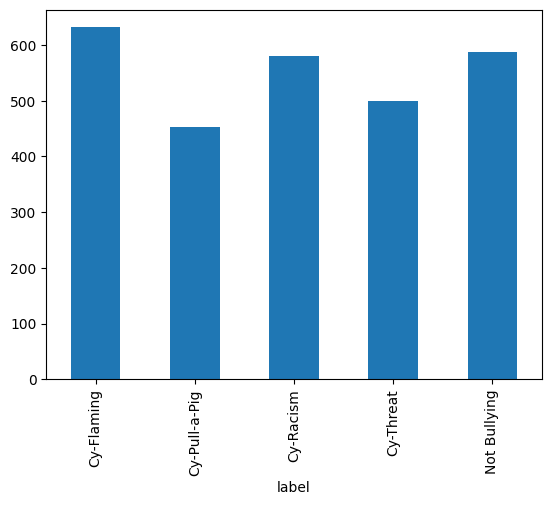

In [ ]:
df.groupby(['label']).size().plot.bar()

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.6 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')


#from transformers import AutoTokenizer, AutoModelForPreTraining

#tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

#model = AutoModelForPreTraining.from_pretrained("csebuetnlp/banglabert")

example_text = 'আমি তাকে মেরে ফেলবো'
bert_input = tokenizer(example_text,padding='max_length', max_length = 10, 
                       truncation=True, return_tensors="pt")


print(bert_input['input_ids'])
print(bert_input['token_type_ids'])
print(bert_input['attention_mask'])


tensor([[ 101, 2169, 2271, 5229, 9387, 2395,  102,    0,    0,    0]])
tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])


In [ ]:
example_text = tokenizer.decode(bert_input.input_ids[0])

print(example_text)

[CLS] আমি তাকে মেরে ফেলবো [SEP] [PAD] [PAD] [PAD]


In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer

#from transformers import AutoTokenizer, AutoModelForPreTraining

#tokenizer = AutoTokenizer.from_pretrained("csebuetnlp/banglabert")

#model = AutoModelForPreTraining.from_pretrained("csebuetnlp/banglabert")


tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')
labels = {'Cy-Flaming':0,
          'Cy-Pull-a-Pig':1,
          'Cy-Racism':2,
          'Cy-Threat':3,
          'Not Bullying':4
          }

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [ ]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=95), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

2200 275 276


In [ ]:
from torch import nn
from transformers import BertModel
#from transformers import AutoTokenizer, AutoModelForPreTraining

from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')




from transformers import BertModel

class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('sagorsarker/bangla-bert-base')
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(768, 5)  # Replace 'num_classes' with the actual number of classes in your task

    def forward(self, input_id, mask):
        outputs = self.bert(input_ids=input_id, attention_mask=mask)
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        return linear_output

In [ ]:

from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def train(model, train_data, val_data, test_data,learning_rate, epochs):
    test = Dataset(test_data)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
                | Train Accuracy: {total_acc_train / len(train_data): .3f} \
                | Val Loss: {total_loss_val / len(val_data): .3f} \
                | Val Accuracy: {total_acc_val / len(val_data): .3f}')
            model.eval()
            test_labels = []
            test_preds = []
            with torch.no_grad():
                for test_input, test_label in test_dataloader:
                    test_labels += test_label.tolist()
                    test_label = test_label.to(device)
                    mask = test_input['attention_mask'].to(device)
                    input_id = test_input['input_ids'].squeeze(1).to(device)
                    output = model(input_id, mask)
                    preds = output.argmax(dim=1).tolist()
                    test_preds += preds
            precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
            print(f'Test Precision: {precision:.4f} | Test Recall: {recall:.4f} | Test F1 Score: {f1_score:.4f}')
        
                  
EPOCHS = 17
model = BertClassifier()
LR = 1e-5
              
train(model, df_train, df_val,df_test ,LR, EPOCHS)



"""
from torch.optim import Adam
from tqdm import tqdm
from sklearn.metrics import precision_recall_fscore_support

def train(model, train_data, val_data, test_data, learning_rate, epochs):

    # create dataloaders for training, validation, and test sets
    train, val ,test= Dataset(train_data), Dataset(val_data),Dataset(test_data)
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)



    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    # create optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    for epoch_num in range(epochs):

        # training loop
         for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label.long())
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

        # test loop
        model.eval()
        test_labels = []
        test_preds = []
        with torch.no_grad():
            for test_input, test_label in test_dataloader:
                test_labels += test_label.tolist()
                test_label = test_label.to(device)
                mask = test_input['attention_mask'].to(device)
                input_id = test_input['input_ids'].squeeze(1).to(device)
                output = model(input_id, mask)
                preds = output.argmax(dim=1).tolist()
                test_preds += preds
        precision, recall, f1_score, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
        print(f'Test Precision: {precision:.4f} | Test Recall: {recall:.4f} | Test F1 Score: {f1_score:.4f}')

        # update model parameters
        
"""


Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 1100/1100 [04:18<00:00,  4.25it/s]


Epochs: 1 | Train Loss:  0.486                 | Train Accuracy:  0.633                 | Val Loss:  0.336                 | Val Accuracy:  0.778
Test Precision: 0.7561 | Test Recall: 0.7464 | Test F1 Score: 0.7466


100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]


Epochs: 2 | Train Loss:  0.161                 | Train Accuracy:  0.886                 | Val Loss:  0.325                 | Val Accuracy:  0.764
Test Precision: 0.7940 | Test Recall: 0.7717 | Test F1 Score: 0.7719


100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]


Epochs: 3 | Train Loss:  0.047                 | Train Accuracy:  0.973                 | Val Loss:  0.388                 | Val Accuracy:  0.767
Test Precision: 0.7634 | Test Recall: 0.7572 | Test F1 Score: 0.7571


100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]


Epochs: 4 | Train Loss:  0.014                 | Train Accuracy:  0.994                 | Val Loss:  0.467                 | Val Accuracy:  0.785
Test Precision: 0.7782 | Test Recall: 0.7428 | Test F1 Score: 0.7426


100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]


Epochs: 5 | Train Loss:  0.015                 | Train Accuracy:  0.992                 | Val Loss:  0.509                 | Val Accuracy:  0.735
Test Precision: 0.7125 | Test Recall: 0.7101 | Test F1 Score: 0.7053


100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]


Epochs: 6 | Train Loss:  0.040                 | Train Accuracy:  0.975                 | Val Loss:  0.460                 | Val Accuracy:  0.771
Test Precision: 0.7742 | Test Recall: 0.7754 | Test F1 Score: 0.7740


100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]


Epochs: 7 | Train Loss:  0.019                 | Train Accuracy:  0.989                 | Val Loss:  0.525                 | Val Accuracy:  0.749
Test Precision: 0.7616 | Test Recall: 0.7609 | Test F1 Score: 0.7588


100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]


Epochs: 8 | Train Loss:  0.008                 | Train Accuracy:  0.995                 | Val Loss:  0.495                 | Val Accuracy:  0.789
Test Precision: 0.7629 | Test Recall: 0.7609 | Test F1 Score: 0.7601


100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]


Epochs: 9 | Train Loss:  0.012                 | Train Accuracy:  0.992                 | Val Loss:  0.512                 | Val Accuracy:  0.785
Test Precision: 0.7720 | Test Recall: 0.7717 | Test F1 Score: 0.7713


100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]


Epochs: 10 | Train Loss:  0.011                 | Train Accuracy:  0.993                 | Val Loss:  0.620                 | Val Accuracy:  0.745
Test Precision: 0.7536 | Test Recall: 0.7464 | Test F1 Score: 0.7466


100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]


Epochs: 11 | Train Loss:  0.016                 | Train Accuracy:  0.991                 | Val Loss:  0.520                 | Val Accuracy:  0.764
Test Precision: 0.7480 | Test Recall: 0.7355 | Test F1 Score: 0.7376


100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]


Epochs: 12 | Train Loss:  0.020                 | Train Accuracy:  0.986                 | Val Loss:  0.805                 | Val Accuracy:  0.702
Test Precision: 0.7776 | Test Recall: 0.6993 | Test F1 Score: 0.6980


100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]


Epochs: 13 | Train Loss:  0.011                 | Train Accuracy:  0.992                 | Val Loss:  0.523                 | Val Accuracy:  0.800
Test Precision: 0.8064 | Test Recall: 0.7971 | Test F1 Score: 0.7963


100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]


Epochs: 14 | Train Loss:  0.010                 | Train Accuracy:  0.996                 | Val Loss:  0.613                 | Val Accuracy:  0.760
Test Precision: 0.8083 | Test Recall: 0.7971 | Test F1 Score: 0.7937


100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]


Epochs: 15 | Train Loss:  0.020                 | Train Accuracy:  0.986                 | Val Loss:  0.562                 | Val Accuracy:  0.778
Test Precision: 0.7795 | Test Recall: 0.7754 | Test F1 Score: 0.7737


100%|██████████| 1100/1100 [04:14<00:00,  4.33it/s]


Epochs: 16 | Train Loss:  0.013                 | Train Accuracy:  0.992                 | Val Loss:  0.625                 | Val Accuracy:  0.749
Test Precision: 0.7952 | Test Recall: 0.7935 | Test F1 Score: 0.7934


100%|██████████| 1100/1100 [04:14<00:00,  4.32it/s]


Epochs: 17 | Train Loss:  0.002                 | Train Accuracy:  0.999                 | Val Loss:  0.621                 | Val Accuracy:  0.771
Test Precision: 0.8154 | Test Recall: 0.8116 | Test F1 Score: 0.8118


'\nfrom torch.optim import Adam\nfrom tqdm import tqdm\nfrom sklearn.metrics import precision_recall_fscore_support\n\ndef train(model, train_data, val_data, test_data, learning_rate, epochs):\n\n    # create dataloaders for training, validation, and test sets\n    train, val ,test= Dataset(train_data), Dataset(val_data),Dataset(test_data)\n    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)\n    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)\n    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)\n\n\n\n    use_cuda = torch.cuda.is_available()\n    device = torch.device("cuda" if use_cuda else "cpu")\n\n    # create optimizer and loss function\n    criterion = nn.CrossEntropyLoss()\n    optimizer = Adam(model.parameters(), lr=learning_rate)\n\n    for epoch_num in range(epochs):\n\n        # training loop\n         for epoch_num in range(epochs):\n\n            total_acc_train = 0\n            total_loss_train = 0\n\n  

In [ ]:
labels = {'Cy-Flaming':0,
          'Cy-Pull-a-Pig':1,
          'Cy-Racism':2,
          'Cy-Threat':3,
          'Not Bullying':4}
inv_labels = {v: k for k, v in labels.items()}

# evaluate on test set and get individual metrics for each class
test = Dataset(df_test)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
test_labels = []
test_preds = []
with torch.no_grad():
    for test_input, test_label in test_dataloader:
        test_labels += test_label.tolist()
        test_label = test_label.to(device)
        mask = test_input['attention_mask'].to(device)
        input_id = test_input['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask)
        preds = output.argmax(dim=1).tolist()
        test_preds += preds

precision, recall, f1_score, support = precision_recall_fscore_support(test_labels, test_preds, labels=list(labels.values()), average=None)

# print individual metrics for each class
for i, label in inv_labels.items():
    print(f"Metrics for {label}:")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1_score[i]:.4f}")
    print(f"Support: {support[i]}")
#This code first defines the mapping between the class labels and their corresponding indices, and then uses precision_recall_fscore_support with labels=list(labels.values()) and average=None to get the individual metrics for each class. Finally, it prints the metrics for each class using the inv_labels dictionary to map the indices back to their original labels.








Metrics for Cy-Flaming:
Precision: 0.7200
Recall: 0.8182
F1-score: 0.7660
Support: 66
Metrics for Cy-Pull-a-Pig:
Precision: 0.7838
Recall: 0.7073
F1-score: 0.7436
Support: 41
Metrics for Cy-Racism:
Precision: 0.8305
Recall: 0.8596
F1-score: 0.8448
Support: 57
Metrics for Cy-Threat:
Precision: 0.8605
Recall: 0.7551
F1-score: 0.8043
Support: 49
Metrics for Not Bullying:
Precision: 0.8871
Recall: 0.8730
F1-score: 0.8800
Support: 63


In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    #"cuda" if use_cuda else 
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

Test Accuracy:  0.812


#Confusion Matrix


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import re,nltk,json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from tensorflow.keras.layers import LSTM,GRU
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.metrics import average_precision_score,roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
np.random.seed(42)
class color: # Text style
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
# dataset path
# path = '/content/drive/My Drive/Colab Notebooks/NLP Projects/thesis/'

Confusion Matrix:
[[54  4  5  1  2]
 [ 7 29  0  2  3]
 [ 3  1 49  2  2]
 [ 8  1  3 37  0]
 [ 3  2  2  1 55]]


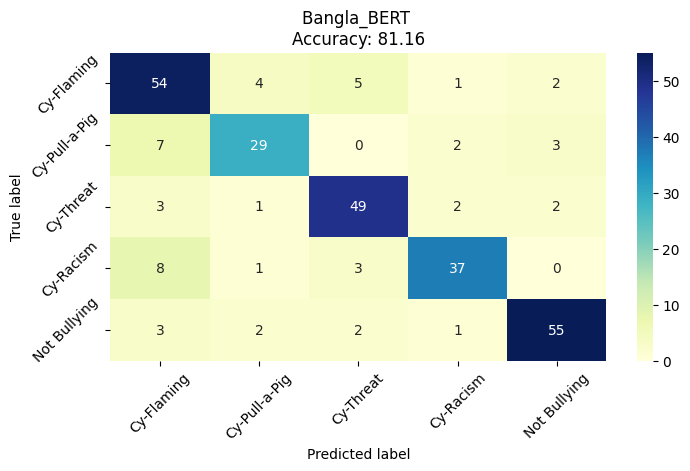

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# ...

test_labels = []
test_preds = []
with torch.no_grad():
    for test_input, test_label in test_dataloader:
        test_labels += test_label.tolist()
        test_label = test_label.to(device)
        mask = test_input['attention_mask'].to(device)
        input_id = test_input['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask)
        preds = output.argmax(dim=1).tolist()
        test_preds += preds

# Calculate precision, recall, f1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(
    test_labels, test_preds, labels=list(labels.values()), average=None
)

# Print individual metrics for each class
# for i, label in inv_labels.items():
#     print(f"Metrics for {label}:")
#     print(f"Precision: {precision[i]:.4f}")
#     print(f"Recall: {recall[i]:.4f}")
#     print(f"F1-score: {f1_score[i]:.4f}")
#     print(f"Support: {support[i]}")

# Calculate confusion matrix
confusion_mat = confusion_matrix(test_labels, test_preds)

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_mat)

cm_df = pd.DataFrame(confusion_mat,
                     
                     index = ['Cy-Flaming' ,'Cy-Pull-a-Pig', 'Cy-Threat','Cy-Racism','Not Bullying'], 
                     columns = ['Cy-Flaming' ,'Cy-Pull-a-Pig', 'Cy-Threat','Cy-Racism','Not Bullying'],)

plt.figure(figsize=(8,4))
sns.heatmap(cm_df, annot=True,cmap="YlGnBu", fmt='g')
plt.title('Bangla_BERT \nAccuracy: {0:.2f}'.format(accuracy_score(test_labels, test_preds)*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation = 45)
plt.yticks(rotation = 45)
plt.show()
